# Comparing posterior distributions
Variational Bayes (VB) is criticised for underestimating the posterior variance. We have compared the posterior variance from the GrandPrix model with the DeLorean VB and the DeLorean MCMC models. 

The experiments have been carried out by using [*Arabidopis
thaliana* microarray dataset (Windram et al., 2012)](https://www.ncbi.nlm.nih.gov/pubmed/23023172) for two different kernel functions:

- RBF kernel
- Matern$_{3/2}$ kernel

The experiments with the DeLorean models have been performed by using the default number of samples. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt
from  GrandPrix import GrandPrix

## Load the data

In [2]:
Y = pd.read_csv('../data/Windram/WindramTrainingData.csv', index_col=[0]).T.values
Y =preprocessing.scale(Y)
mData = pd.read_csv('../data/Windram/WindramMetaData.csv', index_col=[0])

In [3]:
N, D = Y.shape
print('Time Points: %s, Genes: %s'%(N, D))

Time Points: 24, Genes: 100


## Informative prior using the actual captuer time information

In [4]:
actual_capture_time = mData['capture.orig'].values
np.random.seed(10)
sigma_t = 3.
prior_mean = mData['capture'].values[:, None]

X_mean = [prior_mean[i, 0] + sigma_t * np.random.randn(1) for i in range(0, N)] # Initialising latent_mean

## RBF Kernel

### Run the GrandPrix model

In [5]:
pseudotime_rbf, var_rbf = GrandPrix.fit_model(Y, latent_prior_mean=prior_mean, latent_prior_var=np.square(sigma_t),
                             latent_mean=np.asarray(X_mean.copy()), latent_var=0.1,
                             kernel={'name':'RBF', 'ls':18.0, 'var':1.0}, 
                             fix_parameters=['kernel_lengthscales','kernel_variance'], display=True)
print('GrandPrix with RBF kernel: average posterior standard deviation of 24 time points: %f'%np.mean(np.sqrt(var_rbf)))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2661.603898
  Number of iterations: 134
  Number of functions evaluations: 157
GrandPrix with RBF kernel: average posterior standard deviation of 24 time points: 0.915437


### Load the DeLorean results using RBF kernel

#### DeLorean VB model using the RBF kernel

In [6]:
VB_rbf_best = pd.read_csv('../data/Windram/DeLorean_samples/RBF/WindreamDeLoreanBestSample_VB_RBF.csv', index_col=0)
VB_rbf_samples = pd.read_csv('../data/Windram/DeLorean_samples/RBF/WindreamDeLoreanSamples_VB_RBF.csv', index_col=0)
var_VB_rbf = VB_rbf_samples.groupby('capture.orig')['tau'].var()
print('DeLorean VB with RBF kernel: average posterior standard deviation of 24 time points: %f'%np.mean(np.sqrt(var_VB_rbf)))

DeLorean VB with RBF kernel: average posterior standard deviation of 24 time points: 0.536103


#### DeLorean MCMC model using the RBF kernel

In [7]:
MCMC_rbf_best = pd.read_csv('../data/Windram/DeLorean_samples/RBF/WindreamDeLoreanBestSampleMCMC_RBF.csv', index_col=0)
MCMC_rbf_samples = pd.read_csv('../data/Windram/DeLorean_samples/RBF/WindreamDeLoreanSamplesMCMC_MultipleChains_RBF.csv', index_col=0)
ncores = 3
MCMCStdEstimatesPerChain_rbf = np.zeros((N, ncores))
for i in range(N):
    idx = MCMC_rbf_samples.columns.str.contains('tau.%g.'%(i+1), regex=False)
    assert idx.sum() == ncores, 'should be %g chains per cell' % ncores
    MCMCStdEstimatesPerChain_rbf[i, :] = np.std(MCMC_rbf_samples.iloc[:,idx], 0)
MCMCStdOnChains_rbf = np.mean(MCMCStdEstimatesPerChain_rbf, 1)
print('DeLorean MCMC with RBF kernel: average posterior standard deviation of 24 time points: %f'%np.mean(MCMCStdOnChains_rbf))

DeLorean MCMC with RBF kernel: average posterior standard deviation of 24 time points: 0.978899


### Visualise the posterior variance from the models using the RBF kernel

Text(0.5,0,'Capture time')

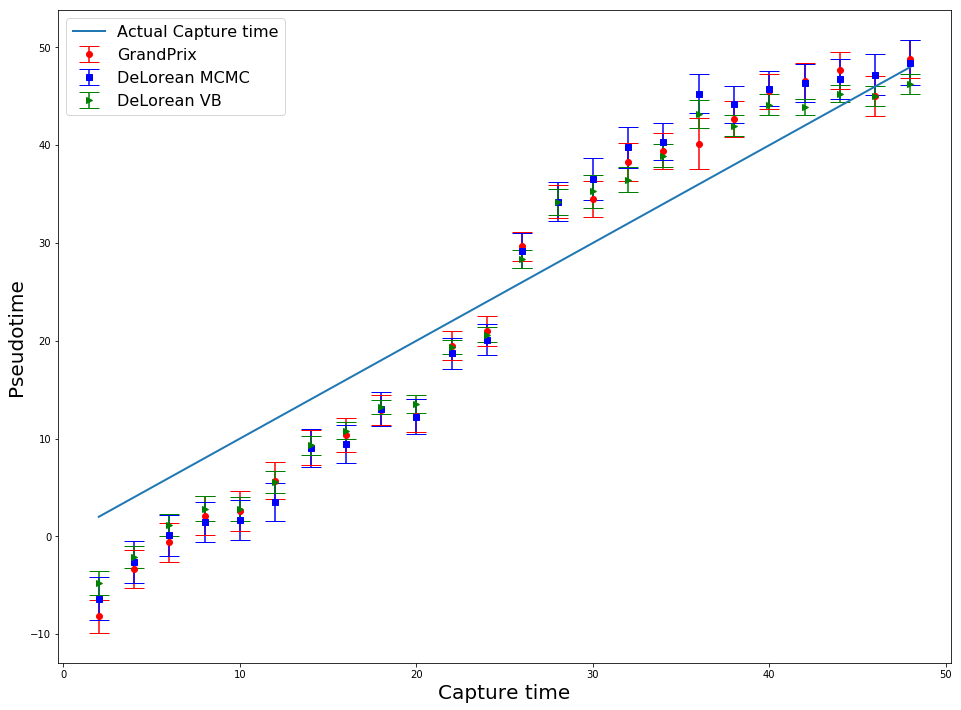

In [8]:
plt.figure(figsize=(16, 12))
plt.errorbar(y=pseudotime_rbf, x=actual_capture_time, yerr=2*np.sqrt(var_rbf), fmt='ro', capsize=10)
plt.errorbar(y=MCMC_rbf_best['tau'], x=actual_capture_time, yerr=2*MCMCStdOnChains_rbf, fmt='bs', capsize=10)
plt.errorbar(y=VB_rbf_best['tau'], x=actual_capture_time, yerr=2*np.sqrt(var_VB_rbf), fmt='g>', capsize=10)
plt.plot(actual_capture_time, actual_capture_time, lw=2)
plt.legend(['Actual Capture time', 'GrandPrix', 'DeLorean MCMC','DeLorean VB'],numpoints=1, loc=2, fontsize=16)
plt.ylabel('Pseudotime', fontsize=20)
plt.xlabel('Capture time', fontsize=20)

## Matern$_\mathbf{3/2}$ kernel

### Run the GrandPrix model

In [9]:
np.random.seed(10)
pseudotime_matern32, var_matern32 = GrandPrix.fit_model(Y, latent_prior_mean=prior_mean, latent_prior_var=np.square(sigma_t),
                             latent_mean=np.asarray(X_mean.copy()), latent_var=9.,
                             kernel={'name':'Matern32', 'ls':18.0, 'var':1.0}, 
                             fix_parameters=['kernel_lengthscales','kernel_variance'], display=True)
print('GrandPrix with Matern32 kernel: average posterior standard deviation of 24 time points: %f'%np.mean(np.sqrt(var_matern32)))

Could not find signature for _expectation: <Gaussian, Matern32, NoneType, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, Matern32, InducingPoints>


/home/sumon/newInstall/GPflow/gpflow/expectations.py:110: UserWarning: Quadrature is used to calculate the expectation. This means that an analytical implementations is not available for the given combination.
  warnings.warn("Quadrature is used to calculate the expectation. This means that "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2591.269237
  Number of iterations: 167
  Number of functions evaluations: 195
GrandPrix with Matern32 kernel: average posterior standard deviation of 24 time points: 0.550991


### Load the DeLorean results using Matern$_\mathbf{3/2}$ kernel

#### DeLorean VB model using the Matern$_\mathbf{3/2}$ kernel

In [10]:
VB_matern32_best = pd.read_csv('../data/Windram/DeLorean_samples/Matern32/WindreamDeLorean_Matern32.csv', index_col=0)
VB_matern32_samples = pd.read_csv('../data/Windram/DeLorean_samples/Matern32/WindreamDeLoreanSamples_Matern32.csv', index_col=0)
var_VB_matern32 = VB_matern32_samples.groupby('capture.orig')['tau'].var()
print('DeLorean VB with Matern32 kernel: average posterior standard deviation of 24 time points: %f'%np.mean(np.sqrt(var_VB_matern32)))

DeLorean VB with Matern32 kernel: average posterior standard deviation of 24 time points: 0.416390


#### DeLorean MCMC model using the Matern$_\mathbf{3/2}$ kernel

In [11]:
MCMC_matern32_best = pd.read_csv('../data/Windram/DeLorean_samples/Matern32/WindreamDeLoreanBestSampleMCMC_Matern32.csv', index_col=0)
MCMC_matern32_samples = pd.read_csv('../data/Windram/DeLorean_samples/Matern32/WindreamDeLoreanSamplesMCMC_MultipleChains_Matern32.csv', index_col=0)
ncores = 11
MCMCStdEstimatesPerChain_matern32 = np.zeros((N, ncores))
for i in range(N):
    idx = MCMC_matern32_samples.columns.str.contains('tau.%g.'%(i+1), regex=False)
    assert idx.sum() == ncores, 'should be %g chains per cell' % ncores
    MCMCStdEstimatesPerChain_matern32[i, :] = np.std(MCMC_matern32_samples.iloc[:,idx], 0)
MCMCStdOnChains_matern32 = np.mean(MCMCStdEstimatesPerChain_matern32, 1)
print('DeLorean VB with Matern32 kernel: average posterior standard deviation of 24 time points: %f'%np.mean(MCMCStdOnChains_matern32))

DeLorean VB with Matern32 kernel: average posterior standard deviation of 24 time points: 0.932187


### Visualise the posterior variance from the models using the Matern$_\mathbf{3/2}$ kernel

Text(0.5,0,'Capture time')

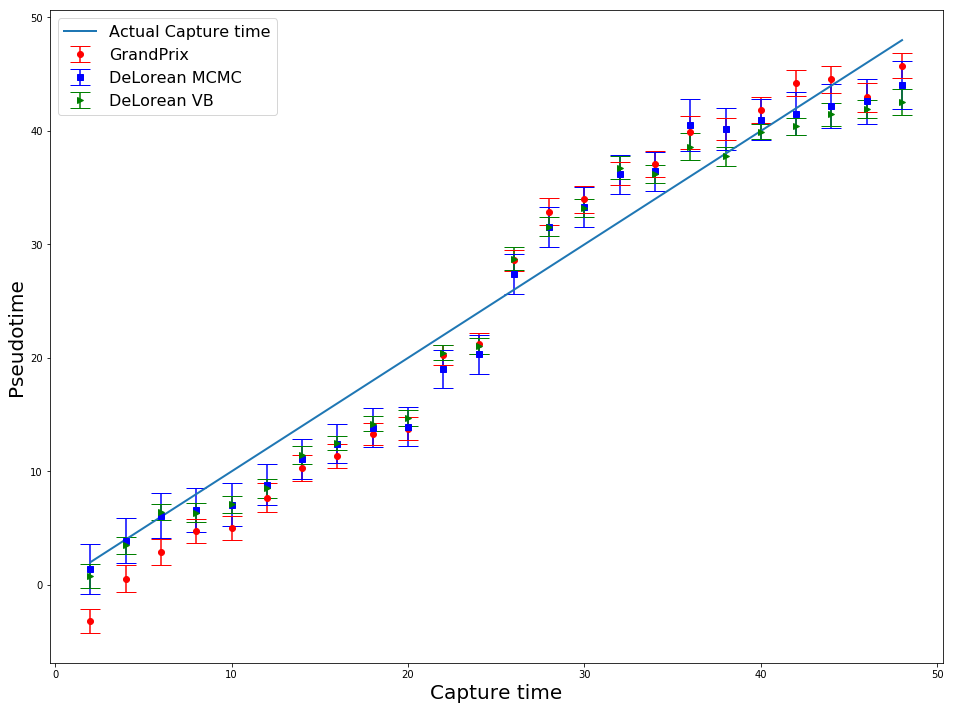

In [12]:
plt.figure(figsize=(16, 12))
plt.errorbar(y=pseudotime_matern32, x=actual_capture_time, yerr=2*np.sqrt(var_matern32), fmt='ro', capsize=10)
plt.errorbar(y=MCMC_matern32_best['tau'], x=actual_capture_time, yerr=2*MCMCStdOnChains_matern32, fmt='bs', capsize=10)
plt.errorbar(y=VB_matern32_best['tau'], x=actual_capture_time, yerr=2*np.sqrt(var_VB_matern32), fmt='g>', capsize=10)
plt.plot(actual_capture_time, actual_capture_time, lw=2)
plt.legend(['Actual Capture time', 'GrandPrix', 'DeLorean MCMC','DeLorean VB'],numpoints=1, loc=2, fontsize=16)
plt.ylabel('Pseudotime', fontsize=20)
plt.xlabel('Capture time', fontsize=20)

## summarisation

The means of the posterior distributions from the models are in good agreement. The GrandPrix model has larger posterior variance than the DeLorean VB model in all the cases. With Matern$_{3/2}$ kernel, the posterior variance from the GrandPrix model is smaller than the DeLorean MCMC. The reason for this may be the absence of the $\Psi$-statistics for Matern$_{3/2}$ kernel in the GPflow package, as we can see that in case of the RBF kernel the posterior variace of GrandPrix is almost same as the DeLorean MCMC. Having unlimited computational resources, the sample variance of an MCMC algorithm is expected to approach the true distribution variance. As GrandPrix uses an exact variational bound to the marginal likelihood, it is expected that the approximate posterior will be closer to the true posterior and similar posterior variances from the DeLorean MCMC and the GrandPrix model for the RBF kernel support this. 

In [13]:
from beautifultable import BeautifulTable
table = BeautifulTable()

table.column_headers = ["Kernel name", "GrandPrix", "DeLorean VB", "DeLorean MCMC"]
table.append_row(["RBF", "%f"%(np.mean(np.sqrt(var_rbf))), "%f"%(np.mean(np.sqrt(var_VB_rbf))), "%f"%(np.mean(MCMCStdOnChains_rbf))])
table.append_row(["Matern32", "%f"%(np.mean(np.sqrt(var_matern32))), "%f"%(np.mean(np.sqrt(var_VB_matern32))), "%f"%(np.mean(MCMCStdOnChains_matern32))])
print('The average standard deviation of the 24 time points')
print(table)

The average standard deviation of the 24 time points
+-------------+-----------+-------------+---------------+
| Kernel name | GrandPrix | DeLorean VB | DeLorean MCMC |
+-------------+-----------+-------------+---------------+
|     RBF     |   0.915   |    0.536    |     0.979     |
+-------------+-----------+-------------+---------------+
|  Matern32   |   0.551   |    0.416    |     0.932     |
+-------------+-----------+-------------+---------------+
